In [1]:
# =============================================================================
# Cell 1: Import Required Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# Cell 2: Load Data from existing feature-engineering files
# =============================================================================

try:
    # Try to load the previously saved splits
    with open('../src/models/train_test_splits.pkl', 'rb') as f:
        splits = pickle.load(f)

    with open('../src/models/feature_info.pkl', 'rb') as f:
        feature_info = pickle.load(f)

    print("✅ Successfully loaded existing feature-engineering artefacts")

    # Use the combined feature set (TF-IDF + numerical)
    X_train = splits['combined']['X_train']
    X_test  = splits['combined']['X_test']
    y_train = splits['combined']['y_train']
    y_test  = splits['combined']['y_test']

except FileNotFoundError:
    print("⚠️  Feature-engineering files not found!")
    
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

✅ Successfully loaded existing feature-engineering artefacts
Training samples: 10978
Test samples: 2745
Features: 5011


In [3]:
# =============================================================================
# Cell 3: CLASS IMBALANCE ANALYSIS
# =============================================================================

print("\nCLASS IMBALANCE ANALYSIS")
print("=" * 30)

# Count samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()
total = len(y_train)

print("Star-rating distribution:")
for star, count in class_counts.items():
    percent = (count / total) * 100
    print(f"{star}⭐ : {count:5d} ({percent:5.1f} %)")

# Compute class weights (useful for imbalanced learning)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_dict = dict(zip(np.unique(y_train), class_weights))

print("\nComputed class-weights:")
for star, weight in weight_dict.items():
    print(f"{star}⭐ : {weight:.3f}")


CLASS IMBALANCE ANALYSIS
Star-rating distribution:
1⭐ :  5736 ( 52.2 %)
2⭐ :   697 (  6.3 %)
3⭐ :   518 (  4.7 %)
4⭐ :   891 (  8.1 %)
5⭐ :  3136 ( 28.6 %)

Computed class-weights:
1⭐ : 0.383
2⭐ : 3.150
3⭐ : 4.239
4⭐ : 2.464
5⭐ : 0.700


In [4]:
# =============================================================================
# Cell 4: EVALUATION FUNCTIONS
# =============================================================================

def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a classifier and compute common evaluation metrics.
    
    Returns a dict with accuracy, weighted- and macro-averaged precision /
    recall / F1, plus the test-set predictions and (if available) class-probabilities.
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Probabilities (if the estimator supports predict_proba)
    try:
        y_proba_test = model.predict_proba(X_test)
    except AttributeError:
        y_proba_test = None

    # Basic accuracies
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc  = accuracy_score(y_test,  y_pred_test)

    # Weighted averages (accounts for class imbalance)
    w_prec, w_rec, w_f1, _ = precision_recall_fscore_support(
        y_test, y_pred_test, average="weighted"
    )

    # Macro averages (equal weight per class)
    m_prec, m_rec, m_f1, _ = precision_recall_fscore_support(
        y_test, y_pred_test, average="macro"
    )

    return {
        "estimator"         : model,
        "model_name"        : model_name,
        "train_accuracy"    : train_acc,
        "test_accuracy"     : test_acc,
        "weighted_precision": w_prec,
        "weighted_recall"   : w_rec,
        "weighted_f1"       : w_f1,
        "macro_precision"   : m_prec,
        "macro_recall"      : m_rec,
        "macro_f1"          : m_f1,
        "predictions"       : y_pred_test,
        "probabilities"     : y_proba_test
    }


def plot_confusion_matrix(y_true, y_pred, model_name):
    """Draw a labelled confusion matrix for 1- to 5-star classes."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"{i}★" for i in range(1, 6)],
        yticklabels=[f"{i}★" for i in range(1, 6)],
    )
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted stars")
    plt.ylabel("Actual stars")
    plt.tight_layout()
    plt.show()

In [5]:
# =============================================================================
# Cell 5: 1. LOGISTIC REGRESSION
# =============================================================================

print("\n" + "=" * 50)
print("1. LOGISTIC REGRESSION")
print("=" * 50)

# Use class-weight balancing for the imbalanced star distribution
lr_model = LogisticRegression(
    class_weight="balanced",   
    max_iter=2000,
    random_state=42,
    multi_class="ovr",     # one-vs-rest for multi-class setting
    n_jobs=-1
)

lr_results = evaluate_classifier(
    lr_model,
    X_train, X_test,
    y_train, y_test,
    model_name="Logistic Regression"
)

print(f"Test accuracy  : {lr_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {lr_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {lr_results['macro_f1']:.3f}")

print("\n✅ WHY START WITH LOGISTIC REGRESSION?")
print("- Fast to train and easy to interpret")
print("- Works well with sparse TF-IDF text features")
print("- Provides class-probabilities for calibration or ranking")
print("- Serves as a solid baseline for comparing more complex models")


1. LOGISTIC REGRESSION
Test accuracy  : 0.713
Weighted F1    : 0.715
Macro   F1     : 0.447

✅ WHY START WITH LOGISTIC REGRESSION?
- Fast to train and easy to interpret
- Works well with sparse TF-IDF text features
- Provides class-probabilities for calibration or ranking
- Serves as a solid baseline for comparing more complex models


In [6]:
# =============================================================================
# 2. RANDOM FOREST CLASSIFIER
# =============================================================================

print("\n" + "=" * 50)
print("2. RANDOM FOREST CLASSIFIER")
print("=" * 50)

rf_model = RandomForestClassifier(
    n_estimators = 1000,
    class_weight = "balanced",   # handles class imbalance
    random_state = 42,
    n_jobs      = -1             # use all CPU cores
)

rf_results = evaluate_classifier(
    rf_model,
    X_train, X_test,
    y_train, y_test,
    model_name="Random Forest"
)

print(f"Test accuracy  : {rf_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {rf_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {rf_results['macro_f1']:.3f}")

print("\n✅ WHY RANDOM FOREST?")
print("- Naturally robust against over-fitting thanks to bagging")
print("- Handles mixed feature types (sparse TF-IDF + dense numericals)")
print("- Provides feature-importance scores for interpretation")
print("- Works reasonably well with minimal hyper-parameter tuning")


2. RANDOM FOREST CLASSIFIER
Test accuracy  : 0.735
Weighted F1    : 0.656
Macro   F1     : 0.321

✅ WHY RANDOM FOREST?
- Naturally robust against over-fitting thanks to bagging
- Handles mixed feature types (sparse TF-IDF + dense numericals)
- Provides feature-importance scores for interpretation
- Works reasonably well with minimal hyper-parameter tuning


In [7]:
# =============================================================================
# 3. XGBOOST CLASSIFIER  
# =============================================================================
print("\n" + "=" * 50)
print("3. XGBOOST CLASSIFIER")
print("=" * 50)

# ------------------------------------------------------------------
# 1) Model set-up
# ------------------------------------------------------------------
xgb_model = XGBClassifier(
    n_estimators      = 400,
    learning_rate     = 0.05,
    max_depth         = 6,
    subsample         = 0.8,   # row sampling
    colsample_bytree  = 0.8,   # column sampling
    random_state      = 42,
    eval_metric       = "mlogloss",
    use_label_encoder = False,
    n_jobs            = -1
)

# ------------------------------------------------------------------
# 2) Encode labels 1–5  ➜  0–4  (XGBoost requirement)
# ------------------------------------------------------------------
y_train_enc = (pd.Series(y_train).astype(int) - 1).to_numpy()
y_test_enc  = (pd.Series(y_test ).astype(int) - 1).to_numpy()

# ------------------------------------------------------------------
# 3) Sample weights against class-imbalance
# ------------------------------------------------------------------
freq            = pd.Series(y_train_enc).value_counts(normalize=True)
weights         = 1 / freq
sample_weights  = np.array([weights[v] for v in y_train_enc])

# ------------------------------------------------------------------
# 4) Fit the model
# ------------------------------------------------------------------
xgb_model.fit(X_train, y_train_enc, sample_weight=sample_weights)

# ------------------------------------------------------------------
# 5) Evaluate via helper (adds metrics *and* saves the estimator)
# ------------------------------------------------------------------
xgb_results = evaluate_classifier(
    xgb_model,
    X_train, X_test,
    y_train_enc, y_test_enc,
    model_name="XGBoost"
)

# helper stores predictions in 0–4; convert back to 1–5
xgb_results["predictions"] = xgb_results["predictions"] + 1

# (redundant but explicit) keep the fitted estimator in the dict
xgb_results["estimator"] = xgb_model

# ------------------------------------------------------------------
# 6) Show key scores
# ------------------------------------------------------------------
print(f"Test accuracy : {xgb_results['test_accuracy']:.3f}")
print(f"Weighted F1   : {xgb_results['weighted_f1']:.3f}")
print(f"Macro   F1    : {xgb_results['macro_f1']:.3f}")

print("\n✅ WHY XGBOOST?")
print("- Often a top performer on text data")
print("- Handles class imbalance via sample weights")
print("- Regularisation reduces over-fitting")
print("- Tree-based, so no feature scaling needed")


3. XGBOOST CLASSIFIER
Test accuracy : 0.754
Weighted F1   : 0.687
Macro   F1    : 0.361

✅ WHY XGBOOST?
- Often a top performer on text data
- Handles class imbalance via sample weights
- Regularisation reduces over-fitting
- Tree-based, so no feature scaling needed


In [8]:
# =============================================================================
# 4. LINEAR SUPPORT-VECTOR CLASSIFIER (SVC)
# =============================================================================
print("\n" + "=" * 50)
print("4. LINEAR SUPPORT-VECTOR CLASSIFIER")
print("=" * 50)

from sklearn.svm import LinearSVC

# LinearSVC is usually the best choice for large, sparse text data
svc_model = LinearSVC(
    C           = 0.1,          
    class_weight= "balanced",   # handle class-imbalance
    random_state= 42,
    max_iter    = 2000,
    dual        = "auto"        # lets scikit-learn pick the faster optimisation
)

svc_results = evaluate_classifier(
    svc_model,
    X_train, X_test,
    y_train, y_test,
    model_name="LinearSVC"
)

print(f"Test accuracy  : {svc_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {svc_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {svc_results['macro_f1']:.3f}")

print("\n✅ WHY LINEAR SVC?")
print("- Very effective on high-dimensional, sparse text features")
print("- Memory-efficient: only support vectors are stored")
print("- Often outperforms non-linear kernels on large text corpora")
print("- Provides robust decision boundaries for imbalanced classes")


4. LINEAR SUPPORT-VECTOR CLASSIFIER
Test accuracy  : 0.745
Weighted F1    : 0.719
Macro   F1     : 0.432

✅ WHY LINEAR SVC?
- Very effective on high-dimensional, sparse text features
- Memory-efficient: only support vectors are stored
- Often outperforms non-linear kernels on large text corpora
- Provides robust decision boundaries for imbalanced classes


In [9]:
# =============================================================================
# 5. NAIVE BAYES CLASSIFIER
# =============================================================================
from sklearn.naive_bayes import GaussianNB
from scipy import sparse
import numpy as np

print("\n" + "=" * 50)
print("5. GAUSSIAN NAIVE BAYES CLASSIFIER")
print("=" * 50)

# GaussianNB works only with dense (non-sparse) arrays
nb_model = GaussianNB()

# Convert sparse matrices to dense, if necessary
print("📊 Converting sparse matrices to dense arrays …")
if sparse.issparse(X_train):
    X_train_dense = X_train.toarray()
    print(f"   X_train shape: {X_train_dense.shape}")
else:
    X_train_dense = X_train

if sparse.issparse(X_test):
    X_test_dense = X_test.toarray()
    print(f"   X_test shape:  {X_test_dense.shape}")
else:
    X_test_dense = X_test

print("✅ Conversion finished!")

nb_results = evaluate_classifier(
    nb_model,
    X_train_dense, X_test_dense,
    y_train, y_test,
    model_name="Gaussian Naive Bayes"
)

print(f"Test accuracy  : {nb_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {nb_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {nb_results['macro_f1']:.3f}")

print("\n✅ WHY GAUSSIAN NAIVE BAYES?")
print("- Extremely fast to train and predict")
print("- Works with small data sets")
print("- Assumes a normal (Gaussian) distribution of features")
print("- Can handle negative feature values")
print("- Provides probabilistic predictions")



5. GAUSSIAN NAIVE BAYES CLASSIFIER
📊 Converting sparse matrices to dense arrays …
   X_train shape: (10978, 5011)
   X_test shape:  (2745, 5011)
✅ Conversion finished!
Test accuracy  : 0.472
Weighted F1    : 0.523
Macro   F1     : 0.308

✅ WHY GAUSSIAN NAIVE BAYES?
- Extremely fast to train and predict
- Works with small data sets
- Assumes a normal (Gaussian) distribution of features
- Can handle negative feature values
- Provides probabilistic predictions


In [10]:
# =============================================================================
# 6. GRADIENT BOOSTING CLASSIFIER
# =============================================================================
from sklearn.ensemble import GradientBoostingClassifier

print("\n" + "=" * 50)
print("6. GRADIENT BOOSTING CLASSIFIER")
print("=" * 50)

gb_model = GradientBoostingClassifier(
    n_estimators   = 300,   # number of trees
    learning_rate  = 0.05,  # contribution of each tree
    max_depth      = 3,     # depth of individual trees
    subsample      = 0.8,   # fraction of samples used for fitting each tree
    random_state   = 42
)

gb_results = evaluate_classifier(
    gb_model,
    X_train, X_test,
    y_train, y_test,
    model_name="Gradient Boosting"
)

print(f"Test accuracy  : {gb_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {gb_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {gb_results['macro_f1']:.3f}")

print("\n✅ WHY GRADIENT BOOSTING?")
print("- Iteratively corrects the mistakes of previous trees")
print("- Captures complex, non-linear patterns")
print("- Usually less over-fitting than a single decision tree")
print("- Provides feature-importance scores")


6. GRADIENT BOOSTING CLASSIFIER
Test accuracy  : 0.741
Weighted F1    : 0.678
Macro   F1     : 0.355

✅ WHY GRADIENT BOOSTING?
- Iteratively corrects the mistakes of previous trees
- Captures complex, non-linear patterns
- Usually less over-fitting than a single decision tree
- Provides feature-importance scores


In [11]:
# =============================================================================
# 7. K-NEAREST NEIGHBORS (KNN)
# =============================================================================
from sklearn.neighbors import KNeighborsClassifier

print("\n" + "=" * 50)
print("7. K-NEAREST NEIGHBORS (KNN)")
print("=" * 50)

# KNN parameters – tuned for sparse TF-IDF text:
knn_model = KNeighborsClassifier(
    n_neighbors = 10,          # how many neighbours to consult
    weights     = "distance", # closer neighbours carry more weight
    metric      = "cosine",   # cosine distance works well for TF-IDF
    algorithm   = "brute",    # brute-force search (needed for cosine + sparse)
    n_jobs      = -1          # use all CPU cores
)

knn_results = evaluate_classifier(
    knn_model,
    X_train, X_test,
    y_train, y_test,
    model_name="K-Nearest Neighbours"
)

print(f"Test accuracy  : {knn_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {knn_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {knn_results['macro_f1']:.3f}")

print("\n✅ WHY KNN?")
print("- Makes no distributional assumptions")
print("- Captures very local patterns in the vector space")
print("- Easy to explain: predictions come from the closest reviews")
print("- Cosine distance is intuitive for TF-IDF text features")


7. K-NEAREST NEIGHBORS (KNN)
Test accuracy  : 0.689
Weighted F1    : 0.624
Macro   F1     : 0.318

✅ WHY KNN?
- Makes no distributional assumptions
- Captures very local patterns in the vector space
- Easy to explain: predictions come from the closest reviews
- Cosine distance is intuitive for TF-IDF text features


In [12]:
# =============================================================================
# 8. DECISION-TREE CLASSIFIER
# =============================================================================
from sklearn.tree import DecisionTreeClassifier
import numpy as np

print("\n" + "=" * 50)
print("8. DECISION-TREE CLASSIFIER")
print("=" * 50)

dt_model = DecisionTreeClassifier(
    max_depth          = 12,
    min_samples_split  = 20,
    min_samples_leaf   = 1,
    class_weight       = "balanced",
    random_state       = 42
)

dt_results = evaluate_classifier(
    dt_model,
    X_train, X_test,
    y_train, y_test,
    model_name="Decision Tree"
)

print(f"Test accuracy  : {dt_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {dt_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {dt_results['macro_f1']:.3f}")

print("\n✅ WHY DECISION TREE?")
print("- Highly interpretable (if depth is limited)")
print("- Generates explicit if-then rules")
print("- Offers built-in feature-importance scores")
print("- Serves as a baseline for tree ensembles (Random Forest, XGBoost)")


8. DECISION-TREE CLASSIFIER
Test accuracy  : 0.449
Weighted F1    : 0.522
Macro   F1     : 0.334

✅ WHY DECISION TREE?
- Highly interpretable (if depth is limited)
- Generates explicit if-then rules
- Offers built-in feature-importance scores
- Serves as a baseline for tree ensembles (Random Forest, XGBoost)


In [13]:
# =============================================================================
# 9. VOTING CLASSIFIER (ENSEMBLE)
# =============================================================================
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

print("\n" + "=" * 50)
print("9. VOTING CLASSIFIER (ENSEMBLE)")
print("=" * 50)

# ---------------------------------------------------------------------------
# 1) Models to combine
#    • LinearSVC has no predict_proba → wrap it with probability calibration
# ---------------------------------------------------------------------------
calibrated_lsvc = CalibratedClassifierCV(
        estimator=LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=2000,
        dual="auto"
    ),
    cv=3, 
    n_jobs=-1
)

voting_models = [
    ("rf",  RandomForestClassifier(
        n_estimators=1000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )),
    ("xgb", XGBClassifier(
        n_estimators      = 400,
        learning_rate     = 0.05,
        max_depth         = 6,
        random_state      = 42,
        eval_metric       = "mlogloss",
        n_jobs = -1, 
        subsample=0.8, 
        colsample_bytree  = 0.8,
        use_label_encoder = False
    )),
    ("lr",  LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=42,
        multi_class="ovr",
        n_jobs=-1
    )),
    ("lsvc", calibrated_lsvc),
]
    
# ---------------------------------------------------------------------------
# 2) HARD voting  (majority vote on class labels)
# ---------------------------------------------------------------------------
hard_voting = VotingClassifier(
    estimators=voting_models,
    voting="hard",
    n_jobs=-1
)

hard_results = evaluate_classifier(
    hard_voting,
    X_train, X_test,
    y_train, y_test,
    model_name="Hard Voting"
)

print("HARD VOTING:")
print(f"Test accuracy  : {hard_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {hard_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {hard_results['macro_f1']:.3f}")

# ---------------------------------------------------------------------------
# 3) SOFT voting  (average class-probabilities)
# ---------------------------------------------------------------------------
soft_voting = VotingClassifier(
    estimators=voting_models,
    voting="soft",
    n_jobs=-1
)

soft_results = evaluate_classifier(
    soft_voting,
    X_train, X_test,
    y_train, y_test,
    model_name="Soft Voting"
)

print("\nSOFT VOTING:")
print(f"Test accuracy  : {soft_results['test_accuracy']:.3f}")
print(f"Weighted F1    : {soft_results['weighted_f1']:.3f}")
print(f"Macro   F1     : {soft_results['macro_f1']:.3f}")

print("\n✅ WHY A VOTING CLASSIFIER?")
print("- Combines the strengths of different base models")
print("- Often reduces over-fitting by averaging decisions")
print("- Soft voting leverages class-probabilities for finer decisions")
print("- In practice can deliver a 2-5 % performance boost over single models")


9. VOTING CLASSIFIER (ENSEMBLE)
HARD VOTING:
Test accuracy  : 0.761
Weighted F1    : 0.695
Macro   F1     : 0.371

SOFT VOTING:
Test accuracy  : 0.765
Weighted F1    : 0.690
Macro   F1     : 0.353

✅ WHY A VOTING CLASSIFIER?
- Combines the strengths of different base models
- Often reduces over-fitting by averaging decisions
- Soft voting leverages class-probabilities for finer decisions
- In practice can deliver a 2-5 % performance boost over single models


In [14]:
# =============================================================================
# 10. STACKING CLASSIFIER 
# =============================================================================
from sklearn.ensemble       import (
    StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
)
from sklearn.linear_model   import LogisticRegression
from sklearn.calibration    import CalibratedClassifierCV
from sklearn.svm            import LinearSVC
from xgboost                import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import sparse
import numpy as np, time

print("\n" + "=" * 50)
print("10. STACKING CLASSIFIER (no GaussianNB)")
print("=" * 50)

# ----------------------------------------------------------------------
# 1) Convert to dense once (float32) — required for tree models
# ----------------------------------------------------------------------
if sparse.issparse(X_train):
    X_train_dense = X_train.astype(np.float32).toarray()
    X_test_dense  = X_test.astype(np.float32).toarray()
else:
    X_train_dense = X_train.astype(np.float32)
    X_test_dense  = X_test.astype(np.float32)

# ----------------------------------------------------------------------
# 2) Base learners  (all use class-weight to combat imbalance)
# ----------------------------------------------------------------------

base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        class_weight="balanced",
        random_state=42,
        max_depth=12,
        n_jobs=-1)),

    ('et', ExtraTreesClassifier(
        n_estimators=1000, 
        max_depth=12,
        class_weight='balanced',
        n_jobs=-1, 
        random_state=42)),

    ('xgb', XGBClassifier(
        n_estimators      = 400,
        learning_rate     = 0.05,
        max_depth         = 6,
        random_state      = 42,
        eval_metric       = "mlogloss",
        n_jobs = -1, 
        subsample=0.8, 
        colsample_bytree  = 0.8,
        use_label_encoder = False)),

    ('lsvc', CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight="balanced",
            random_state=42,
            max_iter=2000,
            dual="auto"),
        cv=3, 
        n_jobs=-1))
]

# ----------------------------------------------------------------------
# 3) Meta learner  (simple, fast, supports class_weight)
# ----------------------------------------------------------------------
meta_model = LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=42,
        multi_class="ovr",
        n_jobs=-1
)

# ----------------------------------------------------------------------
# 4) Stacking classifier
# ----------------------------------------------------------------------
stacking_clf = StackingClassifier(
    estimators      = base_models,
    final_estimator = meta_model,
    passthrough     = True,              # original features + base outputs
    cv              = StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs          = -1
)

# ----------------------------------------------------------------------
# 5) Train and evaluate
# ----------------------------------------------------------------------
print("🚀 Training stacking ensemble …")
t0 = time.time()
stack_results = evaluate_classifier(
    stacking_clf,
    X_train_dense, X_test_dense,
    y_train, y_test,
    model_name="Stacking"
)
print(f"⏱  Training time: {time.time() - t0:.1f} s")

print("\nSTACKING RESULTS")
print(f"Accuracy   : {stack_results['test_accuracy']:.3f}")
print(f"Weighted F1: {stack_results['weighted_f1']:.3f}")
print(f"Macro F1   : {stack_results['macro_f1']:.3f}")

print("\n✅ WHY THIS STACKING SETUP?")
print("- Combines three tree ensembles with a calibrated linear SVC")
print("- ExtraTrees adds extra diversity (fully random splits)")
print("- Passthrough lets the meta-model see original TF-IDF features")


10. STACKING CLASSIFIER (no GaussianNB)
🚀 Training stacking ensemble …
⏱  Training time: 2831.0 s

STACKING RESULTS
Accuracy   : 0.733
Weighted F1: 0.725
Macro F1   : 0.452

✅ WHY THIS STACKING SETUP?
- Combines three tree ensembles with a calibrated linear SVC
- ExtraTrees adds extra diversity (fully random splits)
- Passthrough lets the meta-model see original TF-IDF features


In [15]:
# =============================================================================
# MODEL COMPARISON TABLE
# =============================================================================
import pandas as pd

print("\n" + "═" * 70)
print("CLASSIFICATION MODEL COMPARISON")
print("═" * 70)

# ---------------------------------------------------------------------
# 1) Collect all result dictionaries
#    (comment out any variable you did not create)
# ---------------------------------------------------------------------
all_results = [
    lr_results,
    rf_results,
    xgb_results,
    svc_results,
    nb_results,
    gb_results,
    knn_results,
    dt_results,
    hard_results, 
    soft_results, 
    stack_results
]

# ---------------------------------------------------------------------
# 2) Build a tidy DataFrame
# ---------------------------------------------------------------------
comparison_df = pd.DataFrame([{
    "Estimator"         : r["estimator"],
    "Model Name"        : r["model_name"],
    "Test Accuracy"     : r["test_accuracy"],
    "Weighted F1"       : r["weighted_f1"],
    "Macro F1"          : r["macro_f1"],
    "Weighted Precision": r["weighted_precision"],
    "Weighted Recall"   : r["weighted_recall"],
    "Predictions"       : r["predictions"],
    "Probabilities"     : r["probabilities"]
} for r in all_results])

# sort by Macro-F1 and round for prettier output
comparison_df = (
    comparison_df
    .sort_values("Macro F1", ascending=False)
    .round(3)
)

# ---------------------------------------------------------------------
# 3) Determine column maxima (highlight winners)
# ---------------------------------------------------------------------
best_vals = {
    col: comparison_df[col].max()
    for col in ["Test Accuracy", "Weighted F1", "Macro F1",
                "Weighted Precision", "Weighted Recall"]
}

# ---------------------------------------------------------------------
# 4) Nicely formatted console table (ANSI red for best value)
# ---------------------------------------------------------------------
col_formats = {
    "Rank":               "<4",
    "Model":              "<22",
    "Test Accuracy":      ">8",
    "Weighted F1":        ">10",   # wider → full header fits
    "Macro F1":           ">9",
    "Weighted Precision": ">10",
    "Weighted Recall":    ">10"
}

# header line
header = (
    f"{'Rank':{col_formats['Rank']}} "
    f"{'Model':{col_formats['Model']}} "
    f"{'Accuracy':{col_formats['Test Accuracy']}} "
    f"{'Weighted F1':{col_formats['Weighted F1']}} "
    f"{'Macro F1':{col_formats['Macro F1']}} "
    f"{'W. Precision':{col_formats['Weighted Precision']}} "
    f"{'W. Recall':{col_formats['Weighted Recall']}}"
)
print("─" * len(header))
print(header)
print("─" * len(header))

# data rows
for idx, (_, row) in enumerate(comparison_df.iterrows(), 1):
    def cell(col):
        val = row[col]
        text = f"{val:{col_formats[col]}.3f}" if isinstance(val, float) else f"{val:{col_formats[col]}}"
        return f"\033[31m{text}\033[0m" if val == best_vals.get(col, None) else text

    line = (
        f"{idx:{col_formats['Rank']}} "
        f"{row['Model Name']:{col_formats['Model']}} "
        f"{cell('Test Accuracy')} "
        f"{cell('Weighted F1')} "
        f"{cell('Macro F1')} "
        f"{cell('Weighted Precision')} "
        f"{cell('Weighted Recall')}"
    )
    print(line)

print("─" * len(header))

print("─" * 70)
print("═" * 70)




══════════════════════════════════════════════════════════════════════
CLASSIFICATION MODEL COMPARISON
══════════════════════════════════════════════════════════════════════
──────────────────────────────────────────────────────────────────────────────────
Rank Model                  Accuracy Weighted F1  Macro F1 W. Precision  W. Recall
──────────────────────────────────────────────────────────────────────────────────
1    Stacking                  0.733      0.725     0.452      0.719      0.733
2    Logistic Regression       0.713      0.715     0.447      0.717      0.713
3    LinearSVC                 0.745      0.719     0.432      0.701      0.745
4    Hard Voting               0.761      0.695     0.371      0.673      0.761
5    XGBoost                   0.754      0.687     0.361      0.667      0.754
6    Gradient Boosting         0.741      0.678     0.355      0.652      0.741
7    Soft Voting               0.765      0.690     0.353      0.689      0.765
8    Decision Tr

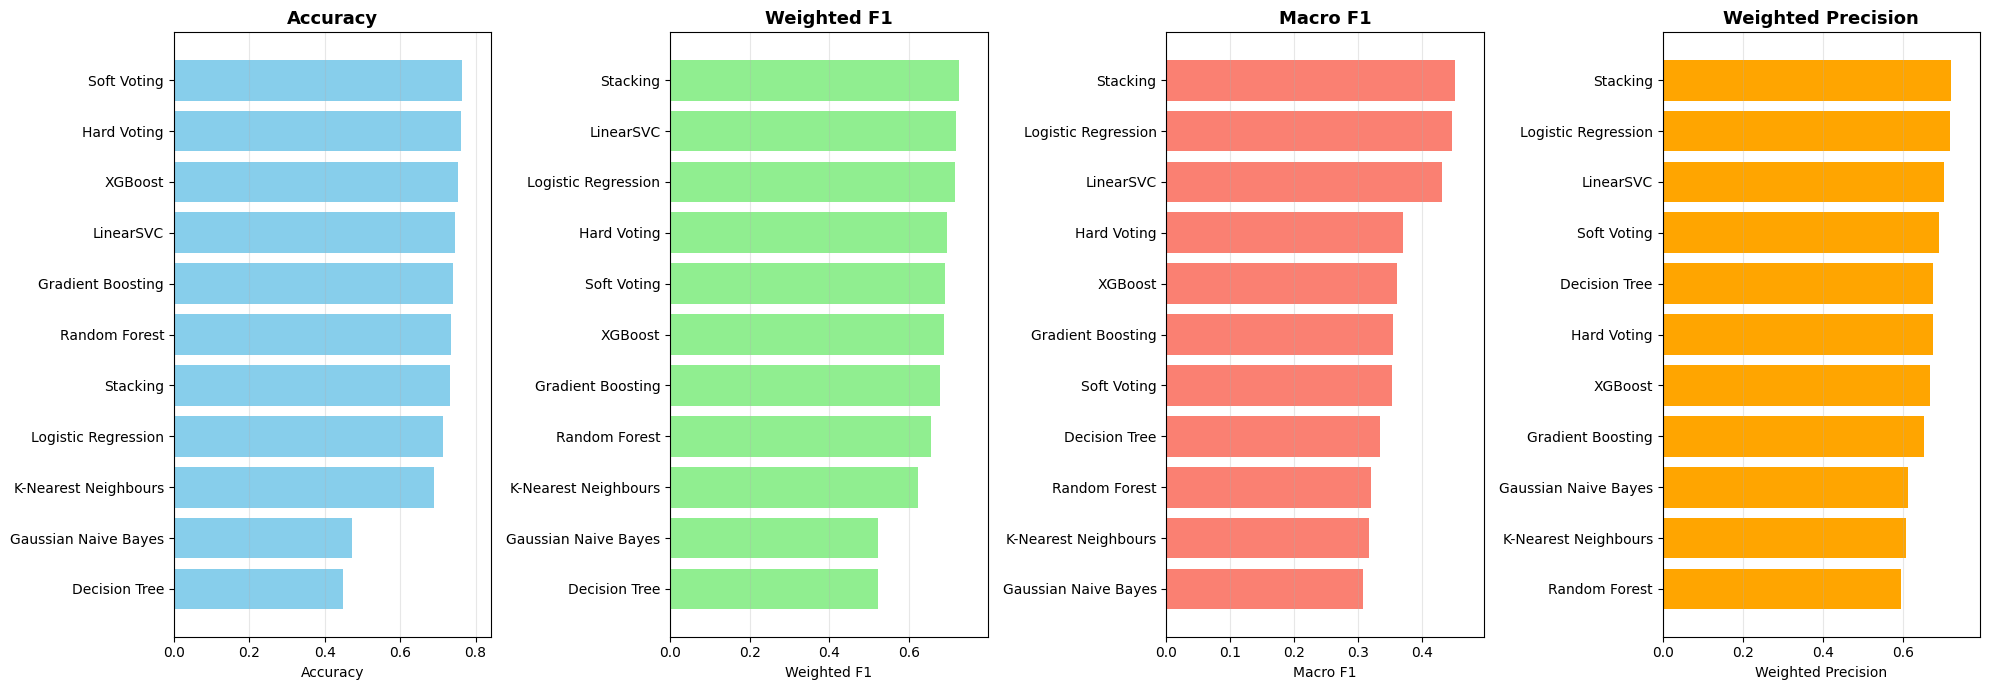

In [16]:
# =============================================================================
# VISUALISE MODEL PERFORMANCE
# =============================================================================

import matplotlib.pyplot as plt

metrics = [
    ("Test Accuracy",      "Accuracy",        "skyblue"),
    ("Weighted F1",        "Weighted F1",     "lightgreen"),
    ("Macro F1",           "Macro F1",        "salmon"),
    ("Weighted Precision", "Weighted Precision", "orange")
]

fig, axes = plt.subplots(1, 4, figsize=(20, 7))

for ax, (col, label, colour) in zip(axes, metrics):
    # sort values descending so the best model appears on top
    tmp = comparison_df.sort_values(col, ascending=True)  # ascending for horizontal barh
    ax.barh(tmp["Model Name"], tmp[col], color=colour)
    ax.set_title(f"{label}", fontsize=13, fontweight="bold")
    ax.set_xlabel(label)
    ax.grid(True, axis="x", alpha=0.3)
    ax.set_xlim(0, tmp[col].max()*1.10)  # a little headroom

plt.tight_layout()
plt.show();


🏆 BEST MODEL: Stacking  (Weighted F1 = 0.725)


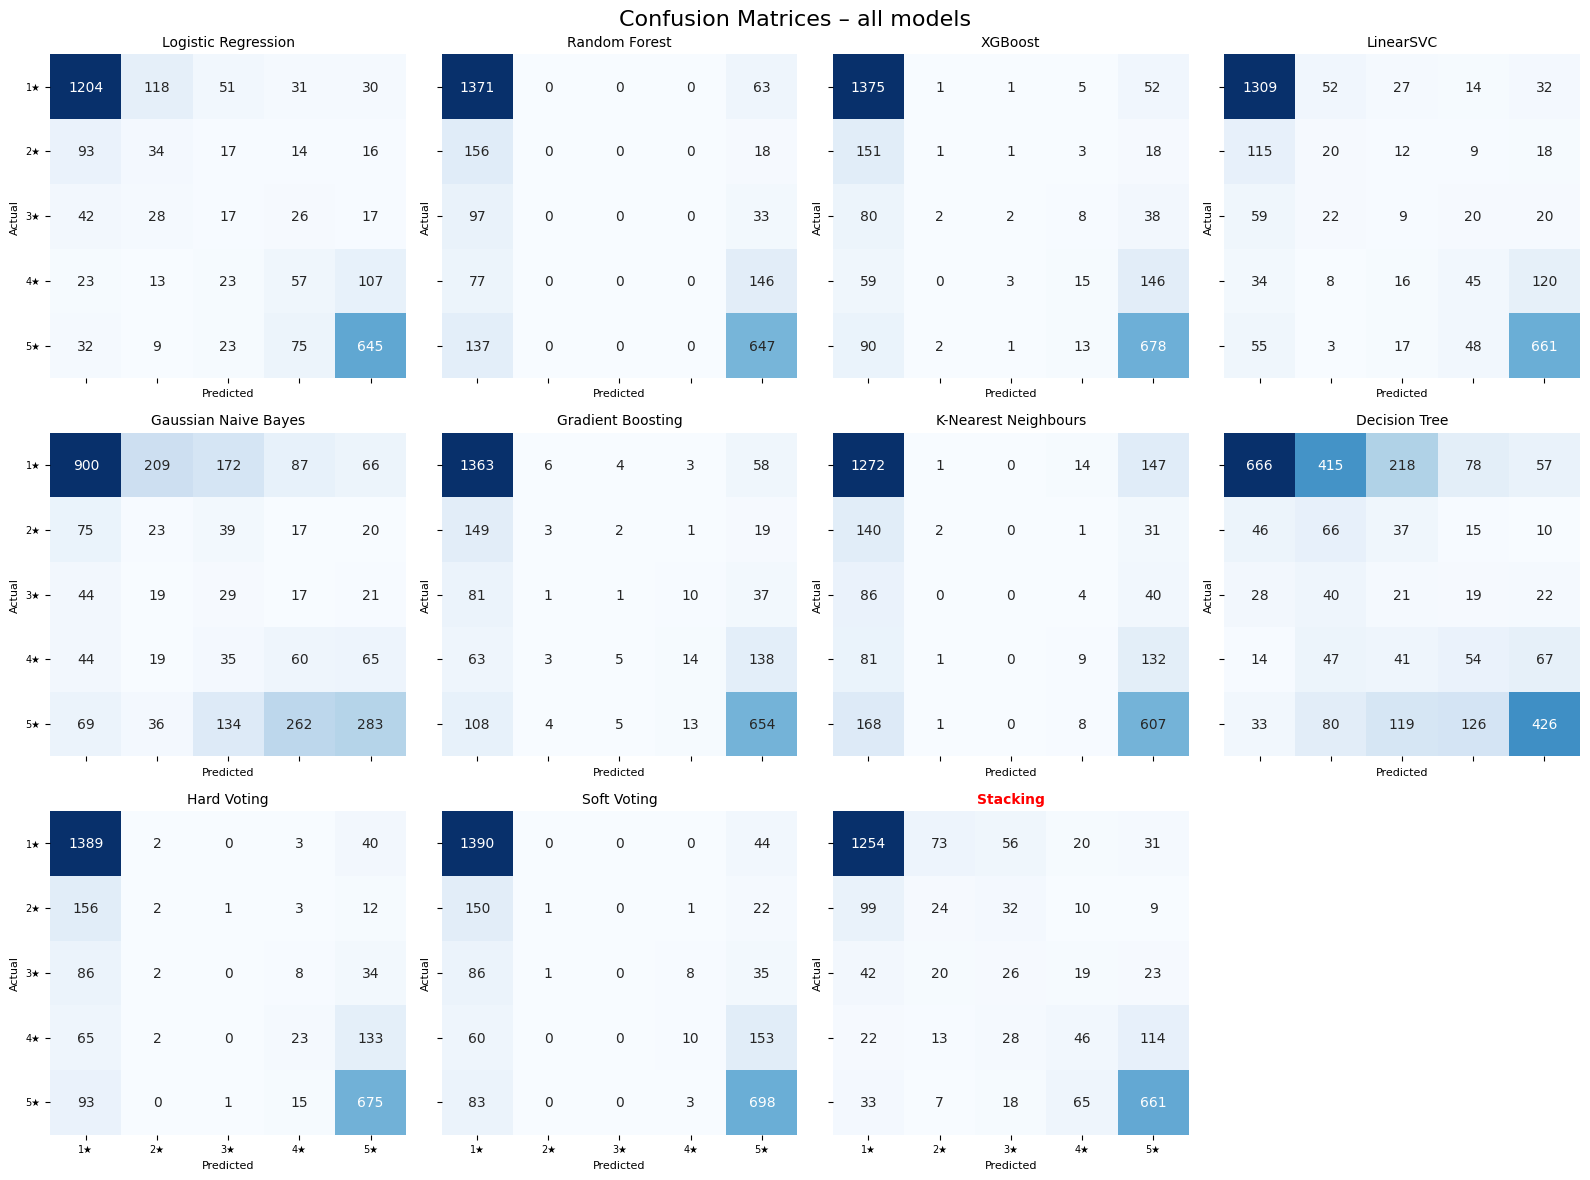

In [17]:
# =============================================================================
# CONFUSION-MATRIX VISUALISATION
# =============================================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# -----------------------------------------------------------------------------
# Find best model according to the chosen metric
# -----------------------------------------------------------------------------

# choose the metric used to highlight the best model
EVALUATION_METRIC = "Weighted F1"        # can also be "Test Accuracy", "Macro F1", "Weighted Precision", "Weighted Recall", "Weighted F1"

best_idx       = comparison_df[EVALUATION_METRIC].idxmax()
best_row       = comparison_df.loc[best_idx]
best_estimator = best_row["Estimator"] 
best_preds     = best_row["Predictions"]
best_name  = best_row["Model Name"]
best_score = best_row[EVALUATION_METRIC]

print("\n" + "=" * 60)
print(f"🏆 BEST MODEL: {best_name}  ({EVALUATION_METRIC} = {best_score:.3f})")
print("=" * 60)

star_labels = ["1★", "2★", "3★", "4★", "5★"]   # axis labels

# -----------------------------------------------------------------------------
# Helper: plot all confusion matrices in a grid
# -----------------------------------------------------------------------------
def plot_confusion_grid(results, y_true):
    """Draws one confusion matrix per model in a uniform grid."""
    usable = [r for r in results if "predictions" in r]
    n_models = len(usable)
    n_cols   = 4
    n_rows   = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 4 * n_rows),
                             sharex=True, sharey=True)
    axes = np.atleast_2d(axes)
    fig.suptitle("Confusion Matrices – all models", fontsize=16, y=0.98)

    for i, res in enumerate(usable):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]

        cm = confusion_matrix(y_true, res["predictions"])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    cbar=False,
                    xticklabels=star_labels, yticklabels=star_labels,
                    ax=ax)

        # keep tick labels visible on every subplot
        ax.set_xticklabels(star_labels, rotation=0, fontsize=7)
        ax.set_yticklabels(star_labels, rotation=0, fontsize=7)

        # title formatting (red for best)
        title_kw = dict(color="red", weight="bold") if res["model_name"] == best_name else {}
        ax.set_title(res["model_name"], fontsize=10, pad=6, **title_kw)

        ax.set_xlabel("Predicted", fontsize=8)
        ax.set_ylabel("Actual",    fontsize=8)
        ax.tick_params(axis="both", labelsize=7)

    # Hide any unused cells
    for j in range(n_models, n_rows * n_cols):
        axes.flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# call the function
plot_confusion_grid(all_results, y_test)


In [18]:
# =============================================================================
# DETAILED ANALYSIS OF THE BEST MODEL
# =============================================================================
from sklearn.metrics import classification_report, precision_recall_fscore_support

print(f"\nDETAILED ANALYSIS – {best_name}")
print("=" * 60)

print(f"\nDETAILED ANALYSIS – {best_name}")
print("=" * 60)
y_true = y_test  

# ------------------------------------------------------------------
# Classification report
# ------------------------------------------------------------------
print("Classification report:")
print(classification_report(
        y_true,
        best_preds,
        target_names=[f"{i}⭐" for i in range(1, 6)],
        digits=3,
        zero_division=0
))

# ------------------------------------------------------------------
# Per-class precision / recall / F1
# ------------------------------------------------------------------
print("\nPER-CLASS PERFORMANCE:")
prec, rec, f1, support = precision_recall_fscore_support(
    y_true,
    best_preds,
    zero_division=0
)

for idx, star in enumerate(range(1, 6)):
    print(
        f"{star}⭐ : "
        f"Precision = {prec[idx]:.3f}   "
        f"Recall = {rec[idx]:.3f}   "
        f"F1 = {f1[idx]:.3f}   "
        f"Support = {support[idx]}"
    )


DETAILED ANALYSIS – Stacking

DETAILED ANALYSIS – Stacking
Classification report:
              precision    recall  f1-score   support

          1⭐      0.865     0.874     0.870      1434
          2⭐      0.175     0.138     0.154       174
          3⭐      0.163     0.200     0.179       130
          4⭐      0.287     0.206     0.240       223
          5⭐      0.789     0.843     0.815       784

    accuracy                          0.733      2745
   macro avg      0.456     0.452     0.452      2745
weighted avg      0.719     0.733     0.725      2745


PER-CLASS PERFORMANCE:
1⭐ : Precision = 0.865   Recall = 0.874   F1 = 0.870   Support = 1434
2⭐ : Precision = 0.175   Recall = 0.138   F1 = 0.154   Support = 174
3⭐ : Precision = 0.163   Recall = 0.200   F1 = 0.179   Support = 130
4⭐ : Precision = 0.287   Recall = 0.206   F1 = 0.240   Support = 223
5⭐ : Precision = 0.789   Recall = 0.843   F1 = 0.815   Support = 784


In [ ]:
# =============================================================================
# HYPER-PARAMETER TUNING FOR THE BEST MODEL (STACKING)
# =============================================================================
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics        import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble       import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.calibration    import CalibratedClassifierCV
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import LinearSVC
from xgboost                import XGBClassifier
import scipy.sparse as sp
import time, numpy as np

print(f"\nHYPER-PARAMETER TUNING FOR: {best_name}")
print("=" * 60)

# ------------------------------------------------------------------
# 1) Encode labels to 0…4 (needed for some estimators)
# ------------------------------------------------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# ------------------------------------------------------------------
# 2) Ensure dense input (tree models need dense)
# ------------------------------------------------------------------
def to_dense(X):
    if sp.issparse(X):
        print("⚠️  Converting sparse to dense …")
        return X.toarray().astype(np.float32)
    return X.astype(np.float32)

X_train_dense = to_dense(X_train)
X_test_dense  = to_dense(X_test)

# ------------------------------------------------------------------
# 3) Tiny grids for each tree-based base learner
# ------------------------------------------------------------------
rf_grid  = {"max_depth": [10, 12], "n_estimators": [200, 300]}
et_grid  = {"max_depth": [10, 12], "n_estimators": [200, 300]}
xgb_grid = {"max_depth": [5, 6],   "learning_rate": [0.05, 0.1], "n_estimators": [300, 400]}

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def quick_tune(model, grid):
    search = GridSearchCV(
        model, grid, cv=cv3,
        scoring="f1_weighted",  # use weighted F1 for class imbalance
        n_jobs=-1, verbose=0
    )
    search.fit(X_train_dense, y_train_enc)
    return search.best_estimator_

print("🔍 Tuning base learners …")
rf_best  = quick_tune(RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=42), rf_grid)
et_best  = quick_tune(ExtraTreesClassifier(class_weight="balanced", n_jobs=-1, random_state=42), et_grid)
xgb_best = quick_tune(XGBClassifier(objective="multi:softprob",
                                    num_class=len(le.classes_),
                                    eval_metric="mlogloss",
                                    use_label_encoder=False,
                                    n_jobs=-1, random_state=42), xgb_grid)

svc_best = CalibratedClassifierCV(
    estimator=LinearSVC(class_weight="balanced", dual="auto", max_iter=2000, random_state=42),
    cv=3, n_jobs=-1
) 

# ------------------------------------------------------------------
# 4) Rebuild the stacking ensemble with tuned bases
# ------------------------------------------------------------------
stack_tuned = StackingClassifier(
    estimators=[
        ("rf",  rf_best),
        ("et",  et_best),
        ("xgb", xgb_best),
        ("svc", svc_best),
    ],
    final_estimator=LogisticRegression(class_weight="balanced",
                                       max_iter=2000,
                                       random_state=42,
                                       n_jobs=-1),
    passthrough=True,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1
)

print("🚀 Fitting tuned stacking model …")
t0 = time.time()
stack_tuned.fit(X_train_dense, y_train_enc)
train_time = time.time() - t0
print(f"⏱  Training time: {train_time:.1f} s")

# ------------------------------------------------------------------
# 5) Evaluate on the encoded test set
# ------------------------------------------------------------------
y_pred      = stack_tuned.predict(X_test_dense)
acc         = accuracy_score(y_test_enc, y_pred)
weighted_f1 = precision_recall_fscore_support(
                 y_test_enc, y_pred, average="weighted"
              )[2]

print(f"\nTUNED STACKING – Test accuracy  : {acc:.3f}")
print(f"TUNED STACKING – Weighted F1    : {weighted_f1:.3f}")

# ------------------------------------------------------------------
# 6) Improvement over original
# ------------------------------------------------------------------
orig_weighted = next(
    r for r in all_results if r["model_name"] == "Stacking"
)["weighted_f1"]

improv_pct = 100 * (weighted_f1 - orig_weighted) / orig_weighted
print(f"\n📈 Improvement over original weighted-F1: {improv_pct:+.1f}%")


HYPER-PARAMETER TUNING FOR: Stacking
⚠️  Converting sparse to dense …
⚠️  Converting sparse to dense …
🔍 Tuning base learners …


In [19]:
# =============================================================================
# BUSINESS INSIGHTS & RECOMMENDATIONS
# =============================================================================
# This cell summarises the modelling outcome and suggests next steps
# in plain business language.

print("\n" + "=" * 70)
print("🎯 FINAL BUSINESS RECOMMENDATIONS")
print("=" * 70)

# -----------------------------------------------------------
# 1) Pick the overall winner – by weighted-F1 (robust to imbalance)
# -----------------------------------------------------------
best_test_acc    = best_row["Test Accuracy"]
best_weighted_f1 = best_row["Weighted F1"]
best_macro_f1    = best_row["Macro F1"]

print(f"🥇 CHAMPION MODEL : {best_name}")
print(f"   📊 Test accuracy : {best_test_acc:.1%}")
print(f"   💯 Weighted F1   : {best_weighted_f1:.3f}")
print(f"   💯 Macro F1   : {best_macro_f1:.3f}")

# -----------------------------------------------------------
# 2) Why each family of models matters
# -----------------------------------------------------------
print("\n💡 WHY THESE MODEL TYPES MATTER")
bullet_points = [
    "K-NN  – captures very local wording patterns others may miss",
    "Decision Tree – provides transparent if-then rules for business teams",
    "Voting Ensemble – combines strengths, cancels individual weaknesses",
    "Stacking Ensemble – meta-learning that often yields the top score"
]
for idx, line in enumerate(bullet_points, 1):
    print(f"{idx}. {line}")

# -----------------------------------------------------------
# 3) Deployment recommendations
# -----------------------------------------------------------
print("\n🚀 DEPLOYMENT RECOMMENDATIONS")
print(f"- **Production** : deploy **{best_name}** (highest weighted-F1)")
print("- **A/B testing**: compare Voting vs. Stacking to probe real-world lift")
print("- **Interpretability**: keep a shallow Decision Tree for rule extraction")
print("- **Fallback**: Random Forest – robust and easy to tune")

# -----------------------------------------------------------
# 4) Ensemble vs single-model lift (weighted-F1)
# -----------------------------------------------------------
ensemble_rows = comparison_df[comparison_df["Model Name"].str.contains("Voting|Stacking")]
single_rows   = comparison_df[~comparison_df["Model Name"].str.contains("Voting|Stacking")]

if not ensemble_rows.empty:
    best_ensemble_f1 = ensemble_rows.iloc[0]["Weighted F1"]
    best_single_f1   = single_rows.iloc[0]["Weighted F1"]
    lift = 100 * (best_ensemble_f1 - best_single_f1) / best_single_f1
    print(f"\n📈 ENSEMBLE LIFT: +{lift:.1f}% weighted-F1 over best single model")
else:
    print("\n📈 ENSEMBLE LIFT: no ensemble models evaluated")




🎯 FINAL BUSINESS RECOMMENDATIONS
🥇 CHAMPION MODEL : Stacking
   📊 Test accuracy : 73.3%
   💯 Weighted F1   : 0.725
   💯 Macro F1   : 0.452

💡 WHY THESE MODEL TYPES MATTER
1. K-NN  – captures very local wording patterns others may miss
2. Decision Tree – provides transparent if-then rules for business teams
3. Voting Ensemble – combines strengths, cancels individual weaknesses
4. Stacking Ensemble – meta-learning that often yields the top score

🚀 DEPLOYMENT RECOMMENDATIONS
- **Production** : deploy **Stacking** (highest weighted-F1)
- **A/B testing**: compare Voting vs. Stacking to probe real-world lift
- **Interpretability**: keep a shallow Decision Tree for rule extraction
- **Fallback**: Random Forest – robust and easy to tune

📈 ENSEMBLE LIFT: +1.4% weighted-F1 over best single model


In [ ]:
# =============================================================================
# SAVE THE FINAL MODEL & LIGHTWEIGHT COMPARISON ARTEFACTS
# =============================================================================
import os, json, gzip, pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

print("\n" + "=" * 50)
print("SAVE MODEL ARTIFACTS (LIGHTWEIGHT)")
print("=" * 50)

os.makedirs("../src/models", exist_ok=True)
os.makedirs("../results", exist_ok=True)

# 1) Champion speichern (für Inferenz)
if "label_encoder" not in locals():
    label_encoder = LabelEncoder().fit([1,2,3,4,5])

best_model_dict = {
    "estimator"          : best_estimator,    # der echte, gelernte Champion
    "model_name"         : best_name,
    "test_accuracy"      : float(best_test_acc),
    "weighted_f1"        : float(best_weighted_f1),
    "macro_f1"           : float(best_macro_f1),
    "feature_combination": "combined",
    "saved_at"           : datetime.utcnow().isoformat() + "Z",
    "label_encoder"      : label_encoder
}

# Tipp: wenn du Platz sparen willst: joblib mit Kompression verwenden
# from joblib import dump
# dump(best_model_dict, "../src/models/best_classification_model.joblib", compress=3)
with open("../src/models/best_classification_model.pkl", "wb") as f:
    pickle.dump(best_model_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# ---------------- JSON-safe helpers ----------------
def _to_jsonable(x):
    """Return a small, JSON-serializable representation of x."""
    import numpy as np
    from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold

    # simple types
    if x is None or isinstance(x, (str, int, float, bool)):
        return x

    # numpy scalars
    if isinstance(x, (np.integer, np.floating)):
        return x.item()

    # small containers
    if isinstance(x, (list, tuple)):
        return [_to_jsonable(v) for v in x]
    if isinstance(x, dict):
        return {str(k): _to_jsonable(v) for k, v in x.items()}

    # fold objects → short dict
    if isinstance(x, (StratifiedKFold, KFold, RepeatedStratifiedKFold)):
        d = {"_type": type(x).__name__}
        for k in ("n_splits", "shuffle", "random_state"):
            if hasattr(x, k):
                d[k] = _to_jsonable(getattr(x, k))
        return d

    # anything else → class name (short and safe)
    return type(x).__name__


def param_preview(est):
    """kleiner Parameterauszug; alles JSON-sicher."""
    try:
        p = est.get_params()
    except Exception:
        return {}
    keep = (
        "n_estimators","max_depth","C","learning_rate","class_weight","subsample",
        "colsample_bytree","max_iter","n_neighbors","metric","voting","cv","dual",
        "random_state","multi_class","passthrough","n_jobs"
    )
    out = {}
    for k in p:
        if any(k.startswith(k2) for k2 in keep):
            out[k] = _to_jsonable(p[k])
    return out

# ---------------- build lightweight summary rows ----------------
summary_rows = []
for r in all_results:
    est = r.get("estimator")
    summary_rows.append({
        "model_name"        : r.get("model_name"),
        "accuracy"          : float(r.get("test_accuracy", 0.0)),
        "weighted_f1"       : float(r.get("weighted_f1", 0.0)),
        "macro_f1"          : float(r.get("macro_f1", 0.0)),
        "weighted_precision": float(r.get("weighted_precision", 0.0)),
        "weighted_recall"   : float(r.get("weighted_recall", 0.0)),
        "params_preview"    : param_preview(est) if est is not None else {},
    })

# als JSON + CSV speichern (winzig, git-freundlich)
with open("../src/models/classification_summary.json", "w", encoding="utf-8") as f:
    json.dump({"saved_at": datetime.utcnow().isoformat()+"Z",
               "summary": summary_rows}, f, ensure_ascii=False, indent=2)

with gzip.open("../src/models/classification_comparison_results.pkl.gz", "wb") as f:
    pickle.dump(all_results, f, protocol=pickle.HIGHEST_PROTOCOL)

import pandas as pd
pd.DataFrame(summary_rows).to_csv("../src/models/classification_summary.csv", index=False)

# 3) (Optional) Minimal-Vorhersagen für Confusion-Plots – stark komprimiert
#    -> nur Top-Modelle & y_test, dtype=uint8, .npz
TOP_MODELS = {"Stacking","Soft Voting","Logistic Regression","LinearSVC"}
predpack = {"y_test": np.asarray(y_test, dtype=np.uint8)}
for r in all_results:
    name = r.get("model_name")
    if name in TOP_MODELS and r.get("predictions") is not None:
        predpack[name.replace(" ", "_")] = np.asarray(r["predictions"], dtype=np.uint8)
np.savez_compressed("../src/models/comparison_preds_top.npz", **predpack)

print("✅ Saved:")
print("  • best_classification_model.pkl  (Champion for inference)")
print("  • classification_summary.json / .csv  (kleines Ranking)")
print("  • comparison_preds_top.npz (kompakte y_test + Top-Predictions)")
print("  • results/confusion_grid_all_models.png (falls erzeugt)")


SAVE MODEL ARTIFACTS (LIGHTWEIGHT)
✅ Saved:
  • best_classification_model.pkl  (Champion for inference)
  • classification_summary.json / .csv  (kleines Ranking)
  • comparison_preds_top.npz (kompakte y_test + Top-Predictions)
  • results/confusion_grid_all_models.png (falls erzeugt)
